Valsecchi et al. (2014) show that, in the limit of large $M_{\rm p}/M_\star$ and conservative mass transfer, $a/a_0 = \left(M_{\rm p}/M_{\rm p,\ 0} \right)^{-1/3}$ (Eqn 14), where $a/a_0$ is the final/initial semi-major axis and $M_{\rm p}/M_{\rm p,\ 0}$ the final/initial planetary mass. Based on this equation, where would we expect the remnants of hot Jupiters that have lost their atmospheres to end up?

In [84]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.units import cds

plt.rcParams['contour.negative_linestyle'] = 'solid'

In [10]:
def calc_smallq_roche_limit(q, Rp=0.1):
    return (q/3.)**(-1./3)*Rp

def Rappaport_Roche_limit(Mp, Rp):
    #Returns Roche limit period for given density
    #  based on Rappaport+ (2013) ApJL 773, L15.

    Earths_density = 5.3*u.g/u.cm**3 #g/cc
    period0 = 9.6/24.*u.day #days

    rhop = Mp/(4.*np.pi/3.*Rp**3.)
    
    return period0*np.sqrt(Earths_density/(rhop.to('g/cm^3')))

#Returns period or semi-major axis, given the other
#  P in days, a in AU, and Mstar in solar masses
def Keplers_Third_Law(P=None, a=None, Mstar=1.*cds.Msun):

    bigG = 4.*np.pi*np.pi/cds.Msun*(cds.au*cds.au*cds.au)/(cds.yr*cds.yr)

    if((P is None) and (a is None)):
        raise ValueError("P or a must be given!")
    elif(a is not None):
        return (a*a*a/(bigG*Mstar/(4.*np.pi*np.pi)))**(1./2)
    elif(P is not None):
        return (P*P*(bigG*Mstar/(4.*np.pi*np.pi)))**(1./3)

In [12]:
#typical hot Jupiter
Mp = 1.*cds.Mjup
Rp = 1.*cds.Rjup
Mcore = 10.*cds.Mgeo

#the Sun
Ms = 1.*cds.Msun
Rs = 1.*cds.Rsun

q = (Mp.to('kg')/Ms.to('kg')).value

a_Roche = calc_smallq_roche_limit(q, Rp=Rp)
P_Roche = Rappaport_Roche_limit(Mp, Rp)

#So where would the planet end up?
a = a_Roche*(Mcore/Mp)**(-1./3)
P = Keplers_Third_Law(a=a, Mstar=Ms)
print(a.to('au').value, P_Roche.to('day').value, P.to('day').value)

(0.02217335479484554, 0.8267995386510552, 1.2059723035426975)


Not too bad!

In [56]:
#These models come from Lopez & Fortney (2013 -- http://iopscience.iop.org/article/10.1088/0004-637X/792/1/1/meta)

def Lopez_core_radius(Mcore):
    MEarth = 1.*cds.Mgeo
    REarth = 1.*cds.Rgeo
    
    return ((Mcore/MEarth).value)**(0.25)*REarth

def Lopez_Renv(Mp, fenv=0.05, Fp=1., age=5e9*u.year):
    MEarth = 1.*cds.Mgeo
    fenv_baseline = 0.05
    Fp_baseline = 1.
    age_baseline = 5e9*u.year
    
    return 2.06*cds.Rgeo*((Mp/MEarth).value)**(-0.21)*\
            (fenv/fenv_baseline)**(0.59)*\
            (Fp/Fp_baseline)**(0.044)*\
            ((age/age_baseline).value)**(-0.18)

#Ignores the apparently small contribution from the radiative exterior
def Lopez_superearth_radius(Mp, fenv=0.05, Fp=1., age=5e9*u.year):
    Mcore = (1. - fenv)*Mp
    Rcore = Lopez_core_radius(Mcore)
    
    Renv = Lopez_Renv(Mp, fenv=fenv, Fp=Fp, age=age)
    
    return (Rcore + Renv).value

print(Lopez_superearth_radius(1.78*cds.Mgeo, fenv=0.1))

3.87221142671


(-3.1, 0.1)

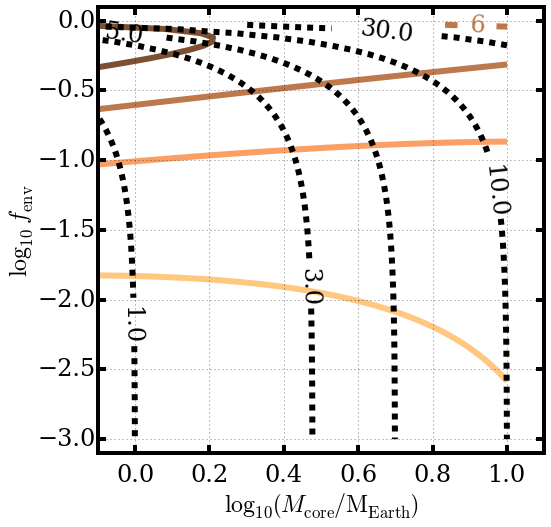

In [96]:
Mcores = 10**(np.linspace(-1., 1., 100))*cds.Mgeo
fenvs = 10**(np.linspace(-3., 0., 101))
#Drop the very last one so I don't get a divide-by-zero error
fenvs = fenvs[:-1]

Mps = np.empty((len(Mcores), len(fenvs)))
Rps = np.empty((len(Mcores), len(fenvs)))
for i in range(len(Mcores)):
    for j in range(len(fenvs)):
        
        cur_Mp = Mcores[i]/(1. - fenv[j])
        Mps[i,j] = cur_Mp.value
        Rps[i,j] = Lopez_superearth_radius(cur_Mp, fenv=fenvs[j])

fenvs = np.outer(np.ones_like(fenvs), fenvs)
Mcores = np.outer(Mcores, np.ones_like(Mcores))

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

lvls = [2, 4, 6, 8, 10, 12]
CS = ax.contour(np.log10(Mcores), np.log10(fenvs), Rps, cmap='copper_r', linewidths=6, levels=lvls)
ax.clabel(CS, inline=1, fontsize=24, fmt='%i')

lvls = [1, 3, 5, 10, 30]
CS = ax.contour(np.log10(Mcores), np.log10(fenvs), Mps, colors='k', linewidths=6, linestyles='dashed', levels=lvls)
ax.clabel(CS, inline=1, fontsize=24, fmt='%.1f')

ax.set_xlabel('$\\log_{10} \\left( M_{\\rm core}/{\\rm M_{Earth}}\\right)$')
ax.set_ylabel('$\\log_{10}\ f_{\\rm env}$')

ax.set_xlim([-0.1, 1.1])
ax.set_ylim([-3.1, 0.1])